In [1]:
import torch
import numpy as np
import pandas as pd
import pdb
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys

sys.path.insert(0, './src')

from kernels import HMC_our, HMC_vanilla, Reverse_kernel
from models import Gen_network, Inf_network
from target import NN_bernoulli
from utils import plot_digit_samples, get_samples
from args import get_args

from data import Dataset

In [2]:

general_name = 'data_mnist_K_2_N_1_fixtransition_False_amortize_False_learnreverse_True_vanillaepoches_0_hoffmanlike_True_learnaccept_True'
NUM_EVALS = 3

In [3]:
args = get_args()

args.device = "cuda:0"
args.std_normal = torch.distributions.Normal(loc=torch.tensor(0., dtype=args.torchType, device=args.device),
                                            scale=torch.tensor(1., dtype=args.torchType, device=args.device))
dataset = Dataset(args, args.device)

In [4]:
for key, value in zip(general_name.split('_')[::2], general_name.split('_')[1::2]):
    if value.isdigit():
        args[key] = int(value)
    elif value in ['True', 'False']:
        args[key] = True if value=='True' else False
    else:
        args[key] = value

In [5]:
#### First, we load train models and fix their params
decoder = torch.load('./models/mnist/best_decoder_{}.pt'.format(general_name), map_location=args.device)
decoder.eval()
for p in decoder.parameters():
    p.requires_grad_(False)
target = NN_bernoulli(args, decoder, args.device)

In [6]:
encoder = torch.load('./models/mnist/best_encoder_{}.pt'.format(general_name), map_location=args.device)
encoder.eval()
for p in encoder.parameters():
    p.requires_grad_(False)

In [7]:
transitions = torch.load('./models/mnist/best_transitions_{}.pt'.format(general_name), map_location=args.device)
transitions.eval()
if args.amortize:
    transitions.device = args.device
else:
    for k in range(args.K):
        transitions[k].device = args.device
for p in transitions.parameters():
    p.requires_grad_(False)

In [8]:
if args.learnable_reverse:
    reverse_kernel = torch.load('./models/mnist/best_reverse_{}.pt'.format(general_name), map_location=args.device)
    reverse_kernel.eval()
    reverse_kernel.device = args.device
    for p in reverse_kernel.parameters():
        p.requires_grad_(False)

In [9]:
if args.numnfpriors:
    priorflow = torch.load('./models/mnist/best_priorflow_{}.pt'.format(general_name), map_location=args.device)
    priorflow.eval()
    priorflow.device = args.device
    for p in priorflow.parameters():
        p.requires_grad_(False)

Saved samples to ./pics/mnist_epoch_-1_K_2_N_1_amortize_False.png


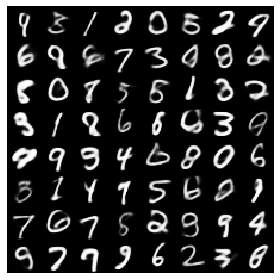

In [10]:
random_code = torch.distributions.Normal(loc=torch.tensor(0., device=args.device),
                                                                 scale=torch.tensor(1., device=args.device)).sample((64, args.z_dim))
rand_code = random_code
# for pflow in priorflow:
#     rand_code = pflow._inverse(rand_code)
plot_digit_samples(samples=get_samples(target.decoder,
                                       rand_code),
                   args=args, epoch=-1)

### NLL estimation using importance sampling with inference part from training

In [10]:
def compute_loss(z_new, p_new, u, p_old, x, sum_log_alpha, sum_log_jac, sum_log_sigma, mu=None, all_directions=None):
    if args.learnable_reverse:
        log_r = reverse_kernel(z_fin=z_new.detach(), mu=mu.detach(), a=all_directions)
        log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac - sum_log_sigma + sum_log_alpha
    else:
        log_r = 0 #-args.K * torch_log_2
        log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac - sum_log_sigma # + sum_log_alpha
    log_p = target.get_logdensity(z=z_new, x=x) + args.std_normal.log_prob(p_new).sum(1)
    elbo_full = log_p + log_r - log_m
    grad_elbo = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
    return elbo_full, grad_elbo

In [11]:
# def compute_marginal_q(z_final, K, x, mu=None, sigma=None):
#     aux_matrix = torch.empty((z_final.shape[0], 3**K), device=device, dtype=torchType)
#     directions_all = np.array(list(itertools.product(np.arange(3) - 1, repeat=K)))
#     cond_distr = torch.distributions.Normal(loc=mu, scale=sigma)
#     for d_num, directions in enumerate(directions_all):
#         sum_log_alpha = torch.zeros(z_final.shape[0], dtype=torchType, device=device) # for grad log alpha accumulation
#         sum_log_jacobian = torch.zeros(z_final.shape[0], dtype=torchType, device=device) # for log_jacobian accumulation
#         z = z_final
#         for k in range(K)[::-1]:
#             if directions[k]==1.:
#                 current_log_alphas = transitions[k].get_log_alpha_1(z_old=z, x=x)
#             elif directions[k]==-1:
#                 current_log_alphas = transitions[k].get_log_alpha_m1(z_old=z, x=x)
#             else:
#                 current_log_alphas = transitions[k].get_log_alpha_0(z_old=z, x=x)
#             z_upd, log_jac = transitions[k].make_transition(z_old=z, x=x, directions=directions[k] * torch.ones(z.shape[0], dtype=torchType, device=device),
#                                                             k=cond_vectors[k]) # sample new positions and log_jacobians of transformations
#             sum_log_jacobian = sum_log_jacobian + log_jac  # refresh log jacobian
#             sum_log_alpha = sum_log_alpha + current_log_alphas
#             z = z_upd
#         log_q_joint = cond_distr.log_prob(z).sum(1) + sum_log_jacobian + sum_log_alpha
#         aux_matrix[:, d_num] = log_q_joint
#     loq_q_marginal = torch.logsumexp(aux_matrix, dim=1)
#     return loq_q_marginal

In [12]:
means = []
stds = []
for _ in range(NUM_EVALS):
    nll = []
    for test_batch in tqdm(dataset.next_test_batch(), total=dataset.test.shape[0] // dataset.test_batch_size):
        mu, sigma = encoder(test_batch)

        sum_log_alpha = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
        sum_log_jacobian = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
        sum_log_sigma = torch.sum(torch.log(sigma), 1)

        u = args.std_normal.sample(mu.shape)
        z = mu + sigma * u

        p_old = args.std_normal.sample(z.shape)
        cond_vectors = [args.std_normal.sample(p_old.shape) for k in range(args.K)]
        p = p_old
        if args.learnable_reverse:
            all_directions = torch.tensor([], device=args.device)
        else:
            all_directions = None

        for k in range(args.K):
    #         pdb.set_trace()
            if args.amortize:
                z, p, log_jac, current_log_alphas, directions, _ = transitions.make_transition(q_old=z, x=test_batch,
                                                    p_old=p, k=cond_vectors[k], target_distr=target)
            else:
                z, p, log_jac, current_log_alphas, directions, _ = transitions[k].make_transition(q_old=z, x=test_batch,
                                                    p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
            if args.learnable_reverse:
                all_directions = torch.cat([all_directions, directions.view(-1, 1)], dim=1)
            sum_log_alpha = sum_log_alpha + current_log_alphas
            sum_log_jacobian = sum_log_jacobian + log_jac  # refresh log jacobian
        nll_current, _ = compute_loss(z_new=z, p_new=p, u=u, p_old=p_old, x=test_batch, sum_log_alpha=sum_log_alpha,
                                    sum_log_jac=sum_log_jacobian, sum_log_sigma=sum_log_sigma, mu=mu, all_directions=all_directions)

        nll.append(nll_current.cpu().detach().numpy())
    means.append(np.mean(nll))

100%|██████████| 1000/1000 [1:38:07<00:00,  5.89s/it]


In [13]:
print(means)

[-94.34207, -94.260765, -94.39794]


In [14]:
print('Mean', np.mean(means))
print('Std', np.std(means))

Mean -94.333595
Std 0.056322087


In [15]:
d = {}
for key, value in zip(general_name.split('_')[::2], general_name.split('_')[1::2]):
    if value.isdigit():
        d[key] = [int(value)]
    elif value in ['True', 'False']:
        d[key] = [True if value=='True' else False]
    else:
        d[key] = [value]
d['Mean'] = [np.mean(means)]
d['std'] = [np.std(means)]
d['eval_method'] = ['IS_with_same_inference_part']

In [16]:
d

{'data': ['mnist'],
 'K': [2],
 'N': [2],
 'fixtransition': [False],
 'amortize': [False],
 'learnreverse': [True],
 'vanillaepoches': [0],
 'hoffmanlike': [True],
 'separateparams': [True],
 'usebatchnorm': [True],
 'decoder': ['deconv'],
 'Mean': [-94.333595],
 'std': [0.056322087],
 'eval_method': ['IS_with_same_inference_part']}

In [17]:
df_cur = pd.DataFrame(data=d, columns=d.keys())
file_name = './nll_results.csv'
if os.path.exists(file_name):
    df = pd.read_csv(file_name)
    df_cur = pd.concat([df, df_cur])
df_cur.to_csv(file_name, index=False)

/home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


### NLL estimation using IS and separately trained encoder

In [11]:
from pyro.nn import AutoRegressiveNN, DenseNN
from pyro.distributions.transforms import NeuralAutoregressive
import torch.nn as nn

In [12]:
encoder_aux = Inf_network(args).to(args.device)
best_encoder_aux = Inf_network(args).to(args.device)
n_flows = 3

flows = []
for i in range(n_flows):
    one_arn = AutoRegressiveNN(args.z_dim, [2 * args.z_dim], param_dims=[2 * args.z_dim] * 3).to(args.device)
    one_flows = NeuralAutoregressive(one_arn, hidden_units=64)
    flows.append(one_flows)
variational_flow = nn.ModuleList(flows)

best_flows = []
for i in range(n_flows):
    one_arn = AutoRegressiveNN(args.z_dim, [2 * args.z_dim], param_dims=[2 * args.z_dim] * 3).to(args.device)
    one_flows = NeuralAutoregressive(one_arn, hidden_units=64)
    best_flows.append(one_flows)
best_variational_flow = nn.ModuleList(best_flows)

params = list(encoder_aux.parameters()) + list(variational_flow.parameters())

optimizer_aux = torch.optim.Adam(params=params)

  0%|          | 0/1000 [00:00<?, ?it/s]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


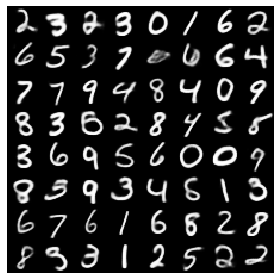

  0%|          | 1/1000 [00:11<3:15:32, 11.74s/it]

Current validation ELBO (epoch 0): -106.96747
Best validation ELBO  -106.96747


  1%|          | 10/1000 [01:56<3:13:07, 11.70s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


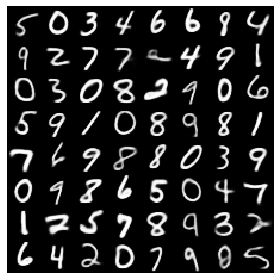

  1%|          | 11/1000 [02:08<3:13:08, 11.72s/it]

Current validation ELBO (epoch 10): -95.08873
Best validation ELBO  -94.84517


  2%|▏         | 20/1000 [03:54<3:11:55, 11.75s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


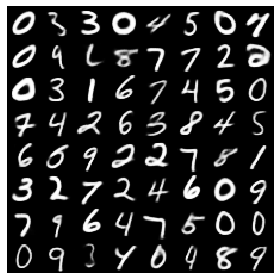

  2%|▏         | 21/1000 [04:06<3:12:03, 11.77s/it]

Current validation ELBO (epoch 20): -94.00307
Best validation ELBO  -93.90632


  3%|▎         | 30/1000 [05:52<3:10:06, 11.76s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


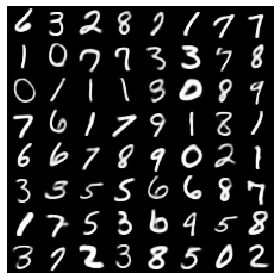

  3%|▎         | 31/1000 [06:03<3:10:17, 11.78s/it]

Current validation ELBO (epoch 30): -93.60133
Best validation ELBO  -93.513054


  4%|▍         | 40/1000 [07:50<3:08:44, 11.80s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


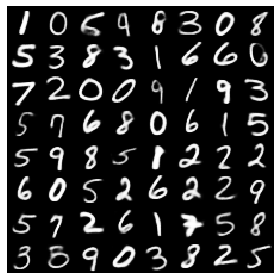

  4%|▍         | 41/1000 [08:01<3:08:48, 11.81s/it]

Current validation ELBO (epoch 40): -93.35175
Best validation ELBO  -93.256004


  5%|▌         | 50/1000 [09:48<3:06:44, 11.79s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


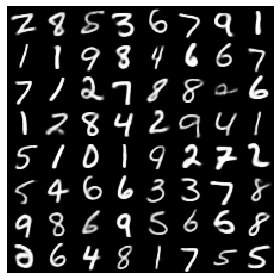

  5%|▌         | 51/1000 [09:59<3:06:49, 11.81s/it]

Current validation ELBO (epoch 50): -93.135025
Best validation ELBO  -92.98091


  6%|▌         | 60/1000 [11:46<3:04:58, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


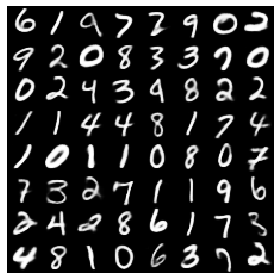

  6%|▌         | 61/1000 [11:58<3:05:01, 11.82s/it]

Current validation ELBO (epoch 60): -92.992516
Best validation ELBO  -92.66688


  7%|▋         | 70/1000 [13:44<3:02:59, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


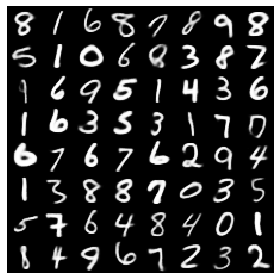

  7%|▋         | 71/1000 [13:56<3:03:02, 11.82s/it]

Current validation ELBO (epoch 70): -92.985794
Best validation ELBO  -92.66688


  8%|▊         | 80/1000 [15:42<3:01:01, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


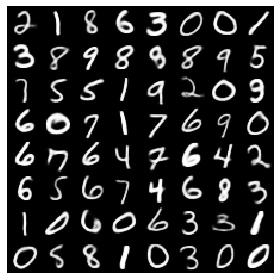

  8%|▊         | 81/1000 [15:54<3:01:05, 11.82s/it]

Current validation ELBO (epoch 80): -92.80683
Best validation ELBO  -92.66688


  9%|▉         | 90/1000 [17:40<2:59:03, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


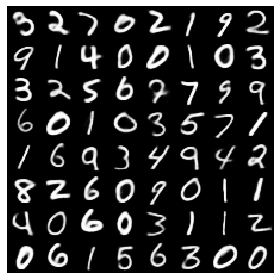

  9%|▉         | 91/1000 [17:52<2:59:06, 11.82s/it]

Current validation ELBO (epoch 90): -92.67443
Best validation ELBO  -92.66002


 10%|█         | 100/1000 [19:38<2:57:08, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


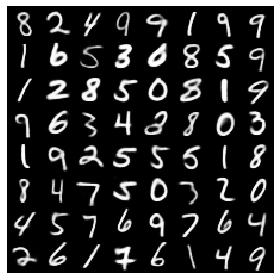

 10%|█         | 101/1000 [19:50<2:57:09, 11.82s/it]

Current validation ELBO (epoch 100): -92.709114
Best validation ELBO  -92.58458


 11%|█         | 110/1000 [21:36<2:55:08, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


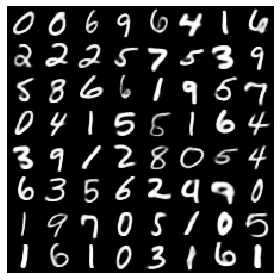

 11%|█         | 111/1000 [21:48<2:55:12, 11.82s/it]

Current validation ELBO (epoch 110): -92.800735
Best validation ELBO  -92.57677


 12%|█▏        | 120/1000 [23:34<2:53:04, 11.80s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


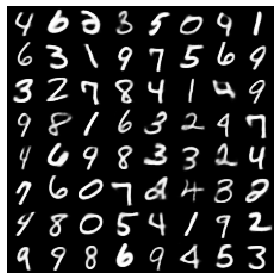

 12%|█▏        | 121/1000 [23:46<2:53:07, 11.82s/it]

Current validation ELBO (epoch 120): -92.867485
Best validation ELBO  -92.57677


 13%|█▎        | 130/1000 [25:33<2:51:14, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


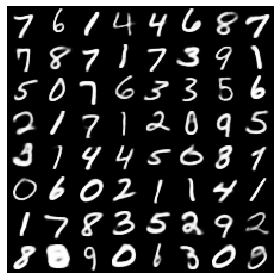

 13%|█▎        | 131/1000 [25:44<2:51:15, 11.82s/it]

Current validation ELBO (epoch 130): -92.649414
Best validation ELBO  -92.51453


 14%|█▍        | 140/1000 [27:31<2:49:17, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


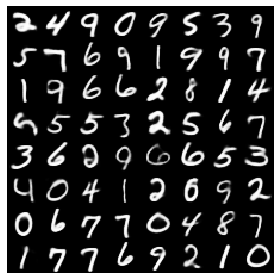

 14%|█▍        | 141/1000 [27:43<2:49:27, 11.84s/it]

Current validation ELBO (epoch 140): -92.507706
Best validation ELBO  -92.36595


 15%|█▌        | 150/1000 [29:30<2:48:52, 11.92s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


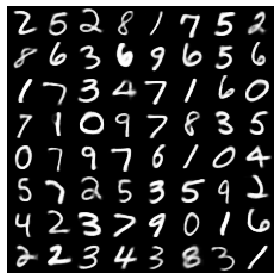

 15%|█▌        | 151/1000 [29:42<2:48:53, 11.94s/it]

Current validation ELBO (epoch 150): -92.66758
Best validation ELBO  -92.36595


 16%|█▌        | 160/1000 [31:28<2:45:27, 11.82s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


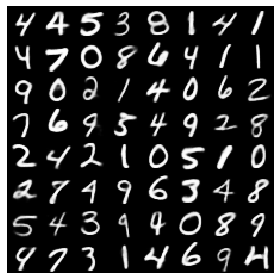

 16%|█▌        | 161/1000 [31:40<2:45:30, 11.84s/it]

Current validation ELBO (epoch 160): -92.643265
Best validation ELBO  -92.35631


 17%|█▋        | 170/1000 [33:27<2:44:58, 11.93s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


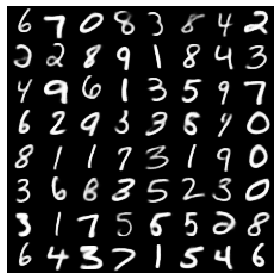

 17%|█▋        | 171/1000 [33:39<2:45:03, 11.95s/it]

Current validation ELBO (epoch 170): -92.55446
Best validation ELBO  -92.320755


 18%|█▊        | 180/1000 [35:26<2:41:20, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


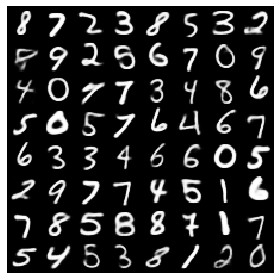

 18%|█▊        | 181/1000 [35:38<2:41:25, 11.83s/it]

Current validation ELBO (epoch 180): -92.50622
Best validation ELBO  -92.320755


 19%|█▉        | 190/1000 [37:24<2:39:25, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


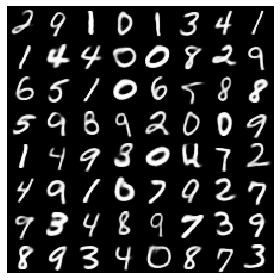

 19%|█▉        | 191/1000 [37:36<2:39:35, 11.84s/it]

Current validation ELBO (epoch 190): -92.45763
Best validation ELBO  -92.320755


 20%|██        | 200/1000 [39:22<2:37:25, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


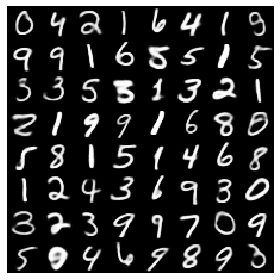

 20%|██        | 201/1000 [39:34<2:37:29, 11.83s/it]

Current validation ELBO (epoch 200): -92.492546
Best validation ELBO  -92.2704


 21%|██        | 210/1000 [41:20<2:35:31, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


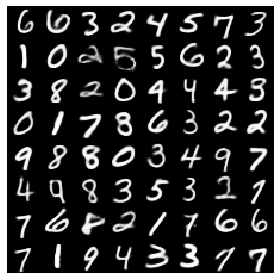

 21%|██        | 211/1000 [41:32<2:35:33, 11.83s/it]

Current validation ELBO (epoch 210): -92.528915
Best validation ELBO  -92.2704


 22%|██▏       | 220/1000 [43:18<2:33:34, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


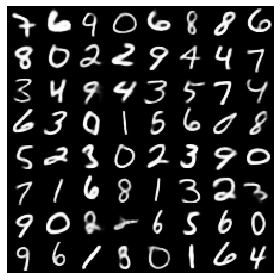

 22%|██▏       | 221/1000 [43:30<2:33:35, 11.83s/it]

Current validation ELBO (epoch 220): -92.40028
Best validation ELBO  -92.20036


 23%|██▎       | 230/1000 [45:17<2:31:37, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


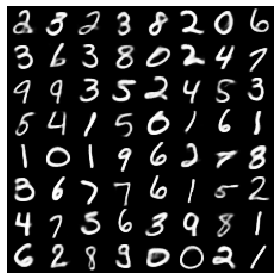

 23%|██▎       | 231/1000 [45:28<2:31:38, 11.83s/it]

Current validation ELBO (epoch 230): -92.381935
Best validation ELBO  -92.20036


 24%|██▍       | 240/1000 [47:15<2:29:39, 11.82s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


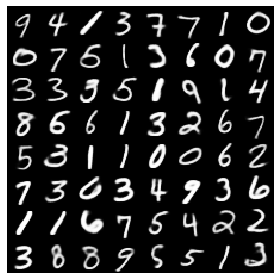

 24%|██▍       | 241/1000 [47:27<2:29:40, 11.83s/it]

Current validation ELBO (epoch 240): -92.4603
Best validation ELBO  -92.19316


 25%|██▌       | 250/1000 [49:13<2:27:38, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


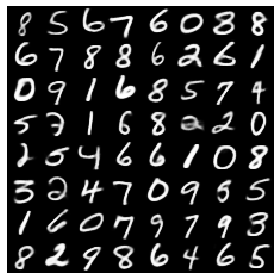

 25%|██▌       | 251/1000 [49:25<2:27:37, 11.83s/it]

Current validation ELBO (epoch 250): -92.39163
Best validation ELBO  -92.17818


 26%|██▌       | 260/1000 [51:11<2:25:35, 11.80s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


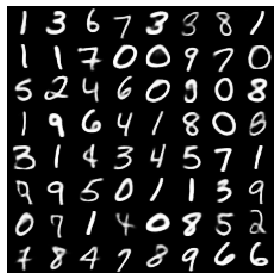

 26%|██▌       | 261/1000 [51:23<2:25:35, 11.82s/it]

Current validation ELBO (epoch 260): -92.59997
Best validation ELBO  -92.17818


 27%|██▋       | 270/1000 [53:09<2:23:45, 11.82s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


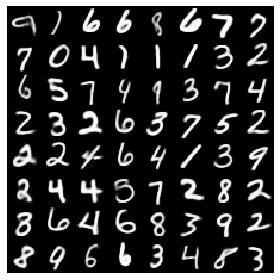

 27%|██▋       | 271/1000 [53:21<2:23:45, 11.83s/it]

Current validation ELBO (epoch 270): -92.40863
Best validation ELBO  -92.13695


 28%|██▊       | 280/1000 [55:07<2:21:45, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


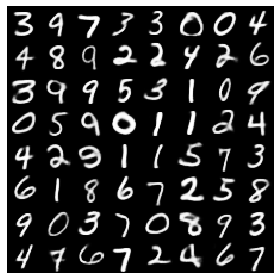

 28%|██▊       | 281/1000 [55:19<2:21:45, 11.83s/it]

Current validation ELBO (epoch 280): -92.15875
Best validation ELBO  -92.13695


 29%|██▉       | 290/1000 [57:06<2:19:46, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


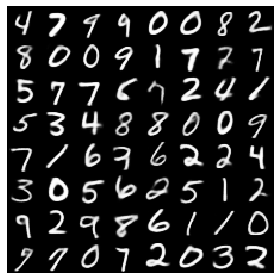

 29%|██▉       | 291/1000 [57:17<2:19:47, 11.83s/it]

Current validation ELBO (epoch 290): -92.265396
Best validation ELBO  -92.101074


 30%|███       | 300/1000 [59:04<2:17:50, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


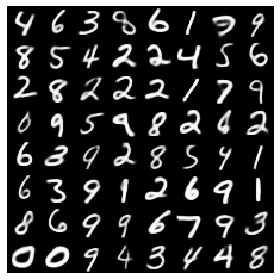

 30%|███       | 301/1000 [59:16<2:17:50, 11.83s/it]

Current validation ELBO (epoch 300): -92.439865
Best validation ELBO  -92.09343


 31%|███       | 310/1000 [1:01:02<2:15:48, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


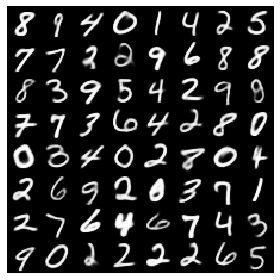

 31%|███       | 311/1000 [1:01:14<2:15:54, 11.84s/it]

Current validation ELBO (epoch 310): -92.34059
Best validation ELBO  -92.09343


 32%|███▏      | 320/1000 [1:03:00<2:13:54, 11.82s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


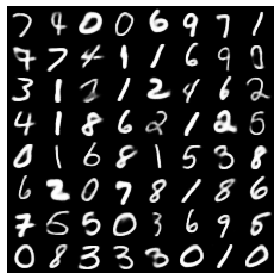

 32%|███▏      | 321/1000 [1:03:12<2:13:53, 11.83s/it]

Current validation ELBO (epoch 320): -92.3163
Best validation ELBO  -92.09343


 33%|███▎      | 330/1000 [1:04:58<2:11:49, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


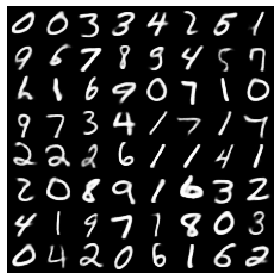

 33%|███▎      | 331/1000 [1:05:10<2:11:54, 11.83s/it]

Current validation ELBO (epoch 330): -92.28183
Best validation ELBO  -92.09343


 34%|███▍      | 340/1000 [1:06:56<2:09:55, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


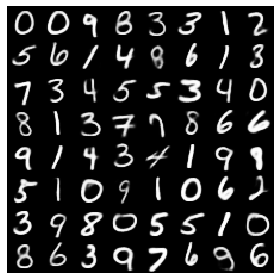

 34%|███▍      | 341/1000 [1:07:08<2:09:54, 11.83s/it]

Current validation ELBO (epoch 340): -92.22176
Best validation ELBO  -92.0516


 35%|███▌      | 350/1000 [1:08:55<2:07:55, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


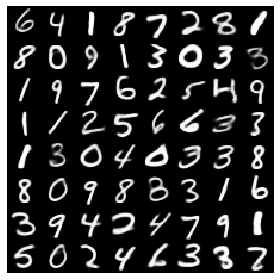

 35%|███▌      | 351/1000 [1:09:07<2:08:02, 11.84s/it]

Current validation ELBO (epoch 350): -92.28548
Best validation ELBO  -92.0516


 36%|███▌      | 360/1000 [1:10:53<2:06:01, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


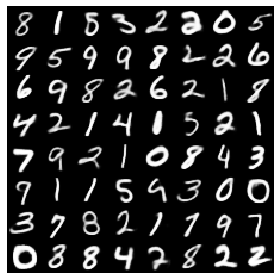

 36%|███▌      | 361/1000 [1:11:05<2:05:58, 11.83s/it]

Current validation ELBO (epoch 360): -92.1612
Best validation ELBO  -92.0516


 37%|███▋      | 370/1000 [1:12:51<2:03:54, 11.80s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


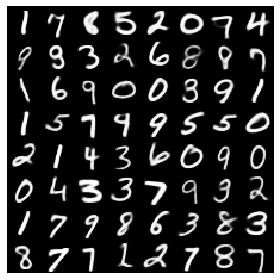

 37%|███▋      | 371/1000 [1:13:03<2:03:53, 11.82s/it]

Current validation ELBO (epoch 370): -92.108505
Best validation ELBO  -92.00661


 38%|███▊      | 380/1000 [1:14:49<2:02:04, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


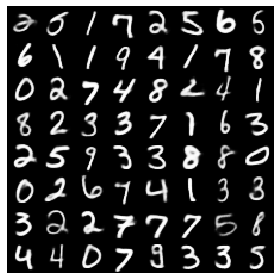

 38%|███▊      | 381/1000 [1:15:01<2:02:02, 11.83s/it]

Current validation ELBO (epoch 380): -92.18666
Best validation ELBO  -92.00661


 39%|███▉      | 390/1000 [1:16:47<1:59:57, 11.80s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


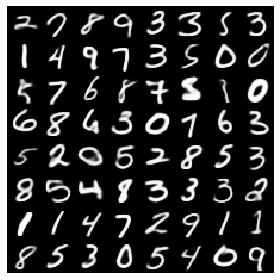

 39%|███▉      | 391/1000 [1:16:59<1:59:56, 11.82s/it]

Current validation ELBO (epoch 390): -92.01946
Best validation ELBO  -92.00661


 40%|████      | 400/1000 [1:18:45<1:58:07, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


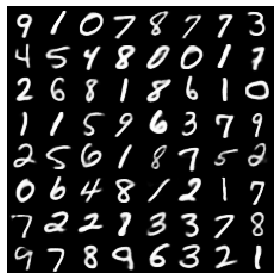

 40%|████      | 401/1000 [1:18:57<1:58:03, 11.83s/it]

Current validation ELBO (epoch 400): -92.122604
Best validation ELBO  -92.00661


 41%|████      | 410/1000 [1:20:43<1:56:04, 11.80s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


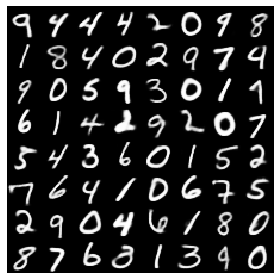

 41%|████      | 411/1000 [1:20:55<1:56:01, 11.82s/it]

Current validation ELBO (epoch 410): -92.07509
Best validation ELBO  -91.96939


 42%|████▏     | 420/1000 [1:22:42<1:54:12, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


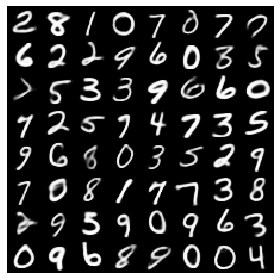

 42%|████▏     | 421/1000 [1:22:54<1:54:10, 11.83s/it]

Current validation ELBO (epoch 420): -92.21831
Best validation ELBO  -91.96939


 43%|████▎     | 430/1000 [1:24:40<1:52:06, 11.80s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


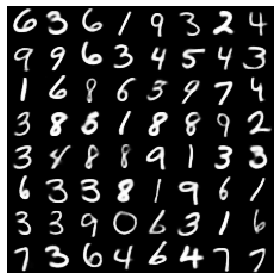

 43%|████▎     | 431/1000 [1:24:52<1:52:04, 11.82s/it]

Current validation ELBO (epoch 430): -92.18282
Best validation ELBO  -91.96939


 44%|████▍     | 440/1000 [1:26:38<1:50:08, 11.80s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


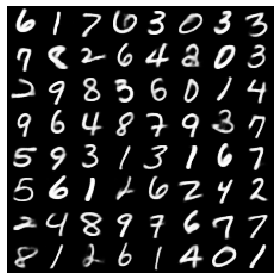

 44%|████▍     | 441/1000 [1:26:50<1:50:05, 11.82s/it]

Current validation ELBO (epoch 440): -92.08475
Best validation ELBO  -91.96939


 45%|████▌     | 450/1000 [1:28:36<1:48:18, 11.82s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


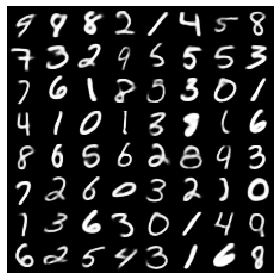

 45%|████▌     | 451/1000 [1:28:48<1:48:16, 11.83s/it]

Current validation ELBO (epoch 450): -92.03556
Best validation ELBO  -91.96939


 46%|████▌     | 460/1000 [1:30:34<1:46:23, 11.82s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


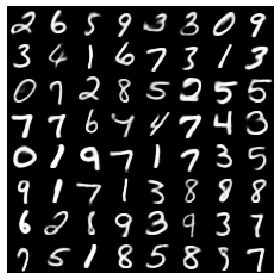

 46%|████▌     | 461/1000 [1:30:46<1:46:18, 11.83s/it]

Current validation ELBO (epoch 460): -92.19786
Best validation ELBO  -91.96939


 47%|████▋     | 470/1000 [1:32:32<1:44:20, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


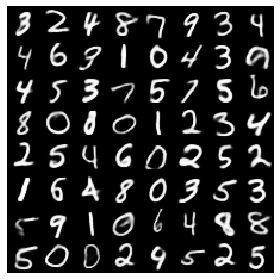

 47%|████▋     | 471/1000 [1:32:44<1:44:19, 11.83s/it]

Current validation ELBO (epoch 470): -92.22913
Best validation ELBO  -91.96939


 48%|████▊     | 476/1000 [1:33:55<1:43:23, 11.84s/it]

Early stopping on epoch 476 (effectively trained for 401 epoches)


In [13]:
##### First, we need to train it #####
best_elbo = -float('inf')
current_tolerance = 0

iterator = tqdm(range(1000))
for ep in iterator:
    for train_batch in dataset.next_train_batch():
        mu, sigma, h = encoder_aux(train_batch)
        u = args.std_normal.sample(mu.shape)
        z = mu + u * sigma
        z_prev = z
        sum_log_jac = 0.
        for flow in variational_flow:
            z_new = flow(z_prev)
            sum_log_jac += flow.log_abs_det_jacobian(z_prev, z_new)
            z_prev = z_new
        log_p = target.get_logdensity(x=train_batch, z=z_new)
        log_q = args.std_normal.log_prob(u).sum(1) - torch.sum(torch.log(sigma), 1) - sum_log_jac
        elbo = torch.mean(log_p - log_q)
        (-elbo).backward()
        optimizer_aux.step()
        optimizer_aux.zero_grad()
    if ep % 10 == 0:
        plot_digit_samples(samples=get_samples(target.decoder,
                                       z_new[:64]),
                   args=args, epoch=-2)
    ##### Validation #####
    elbo_list = []
    for val_batch in dataset.next_val_batch():
        mu, sigma, h = encoder_aux(val_batch)
        u = args.std_normal.sample(mu.shape)
        z = mu + u * sigma
        z_prev = z
        sum_log_jac = 0.
        for flow in variational_flow:
            z_new = flow(z_prev)
            sum_log_jac += flow.log_abs_det_jacobian(z_prev, z_new)
            z_prev = z_new
        log_p = target.get_logdensity(x=val_batch, z=z_new)
        log_q = args.std_normal.log_prob(u).sum(1) - torch.sum(torch.log(sigma), 1) - sum_log_jac
        elbo = torch.mean(log_p - log_q).cpu().detach().numpy()
        elbo_list.append(elbo)
    current_elbo_val = np.mean(elbo_list)
    if (current_elbo_val != current_elbo_val).sum():
        print('NAN appeared!')
        raise ValueError
    if current_elbo_val > best_elbo:
        current_tolerance = 0
        best_elbo = current_elbo_val
        best_encoder_aux.load_state_dict(encoder_aux.state_dict())
        best_variational_flow.load_state_dict(variational_flow.state_dict())
    else:
        current_tolerance += 1
        if current_tolerance >= args.early_stopping_tolerance:
            print("Early stopping on epoch {} (effectively trained for {} epoches)".format(ep,
                                              ep - args.early_stopping_tolerance))
            iterator.close()
            break
    if ep % 10 == 0:
        print('Current validation ELBO (epoch {}):'.format(ep), current_elbo_val)
        print('Best validation ELBO ', best_elbo)

In [14]:
for p in best_encoder_aux.parameters():
    p.requires_grad_(False)
for p in best_variational_flow.parameters():
    p.requires_grad_(False)  

In [15]:
torch.save(best_encoder_aux, './eval_models/best_encoder_aux.pt')
torch.save(best_variational_flow, './eval_models/best_variational_flow.pt')

In [16]:
import gc
del encoder_aux
del variational_flow
del current_elbo_val
del params
del optimizer_aux
del elbo
del elbo_list
del z
del log_p
del log_q
del mu
del sigma
# del encoder
# del transitions
# del reverse_kernel
del sum_log_jac
gc.collect()
torch.cuda.empty_cache()

In [17]:
best_encoder_aux = torch.load('./eval_models/best_encoder_aux.pt')

In [18]:
best_variational_flow = torch.load('./eval_models/best_variational_flow.pt')

In [20]:
means = []
stds = []
for _ in range(NUM_EVALS):
    nll = []
    for test_batch in tqdm(dataset.next_test_batch(), total=dataset.test.shape[0] // dataset.test_batch_size):
        mu, sigma, _ = best_encoder_aux(test_batch)
        sum_log_jacobian = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
        sum_log_sigma = torch.sum(torch.log(sigma), 1)

        u = args.std_normal.sample(mu.shape)
        z = mu + sigma * u

        z_prev = z
        sum_log_jac = 0.
        for flow in best_variational_flow:
            z_new = flow(z_prev)
            sum_log_jac += flow.log_abs_det_jacobian(z_prev, z_new)
            z_prev = z_new
        log_p = target.get_logdensity(x=test_batch, z=z_new)
        log_q = args.std_normal.log_prob(u).sum(1) - torch.sum(torch.log(sigma), 1) - sum_log_jac
        nll_current = torch.mean(log_p - log_q)
        nll.append(nll_current.cpu().detach().numpy())
    means.append(np.mean(nll))

100%|██████████| 1000/1000 [09:31<00:00,  1.75it/s]


In [21]:
d = {}
for key, value in zip(general_name.split('_')[::2], general_name.split('_')[1::2]):
    if value.isdigit():
        d[key] = [int(value)]
    elif value in ['True', 'False']:
        d[key] = [True if value=='True' else False]
    else:
        d[key] = [value]
d['Mean'] = [np.mean(means)]
d['std'] = [np.std(means)]
d['eval_method'] = ['IS_with_separately_trained_inference_part']

In [22]:
d

{'data': ['mnist'],
 'K': [2],
 'N': [1],
 'fixtransition': [False],
 'amortize': [False],
 'learnreverse': [True],
 'vanillaepoches': [0],
 'hoffmanlike': [True],
 'learnaccept': [True],
 'Mean': [-90.713165],
 'std': [0.019081747],
 'eval_method': ['IS_with_separately_trained_inference_part']}

In [22]:
df_cur = pd.DataFrame(data=d, columns=d.keys())
file_name = './nll_results.csv'
if os.path.exists(file_name):
    df = pd.read_csv(file_name)
    df_cur = pd.concat([df, df_cur])
df_cur.to_csv(file_name, index=False)

/home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """
